In [1]:
!pip install deeplay deeptrack  # Uncomment if using Colab/Kaggle.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/TIF360/HW4')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

dataframe = pd.read_csv("jena_climate_2009_2016.csv", index_col=0)
data = dataframe.values
header = dataframe.columns.tolist()

In [4]:
print(dataframe.head())

                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
01.01.2009 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
01.01.2009 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
01.01.2009 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
01.01.2009 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
01.01.2009 00:50:00    996.51     -8.27    265.15        -9.04    94.1   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
01.01.2009 00:10:00          3.33          3.11          0.22       1.94   
01.01.2009 00:20:00          3.23          3.02          0.21       1.89   
01.01.2009 00:30:00          3.21          3.01          0.20       1.88   
01.01.2009 00:40:00          3.26          3.07          0.19       1.92   
01.01.2009 00:50:00      

In [16]:
data = dataframe.values
header = dataframe.columns.tolist()

temperature = data[:, 1]
print(temperature)
print(temperature.shape)

[-8.02 -8.41 -8.51 ... -3.16 -4.23 -4.82]
(420451,)


In [17]:
L = len(temperature)
print(L)

420451


In [27]:
import numpy as np
def no_encoding(seq):
    return seq.reshape(-1, 1)  # (L, 1)

def linear_encoding(seq):
    pos = np.arange(len(seq)) / len(seq)
    pos = pos.reshape(-1, 1)
    return np.concatenate([seq.reshape(-1, 1), pos], axis=1)  # (L, 2)

def periodic_encoding(seq, d_model=64):
    pos = np.arange(len(seq))[:, np.newaxis]      # (L, 1)
    j = np.arange(d_model)[np.newaxis, :]         # (1, d_model)
    angle_rates = pos / np.power(10000, j / d_model)  # (L, d_model)
    pos_encoding = np.zeros_like(angle_rates)

    pos_encoding[:, ::2] = np.sin(angle_rates[:, ::2])
    pos_encoding[:, 1::2] = np.cos(angle_rates[:, 1::2])
    return np.concatenate([seq.reshape(-1, 1), pos_encoding], axis=1)  # (L, d_model+1)



In [28]:
import torch
from torch import nn

In [29]:
import deeplay as dl

class DotProductAttention(dl.DeeplayModule):
    """Dot-product attention."""

    def __init__(self):
        """Initialize dot-product attention."""
        super().__init__()

    def forward(self, queries, keys, values):
        """Calculate dot-product attention."""
        attn_scores = (torch.matmul(queries, keys.transpose(-2, -1))
                       / (keys.size(-1) ** 0.5))
        attn_matrix = torch.nn.functional.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_matrix, values)
        return attn_output, attn_matrix


In [30]:
N = 50
import matplotlib.pyplot as plt
seq_no = torch.from_numpy(no_encoding(temperature[:N])).unsqueeze(0).float()
seq_linear = torch.from_numpy(linear_encoding(temperature[:N])).unsqueeze(0).float()
seq_periodic = torch.from_numpy(periodic_encoding(temperature[:N], d_model=16)).unsqueeze(0).float()

attention = DotProductAttention()
attn_output, attn_matrix_no = attention(
    queries=seq_no, keys=seq_no, values=seq_no,
)
attn_output, attn_matrix_lin = attention(
    queries=seq_linear, keys=seq_linear, values=seq_linear,
)

attn_output, attn_matrix_per = attention(
    queries=seq_periodic, keys=seq_periodic, values=seq_periodic,
)



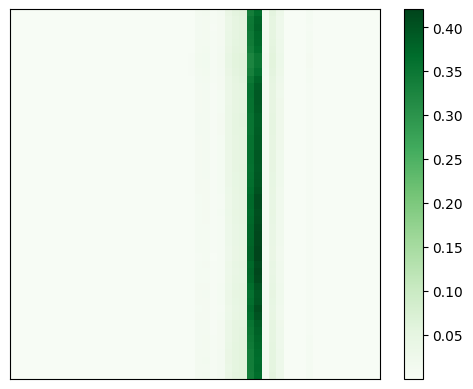

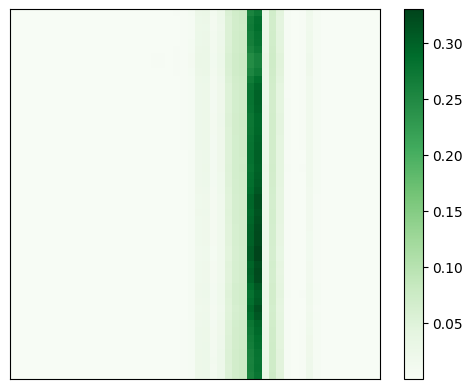

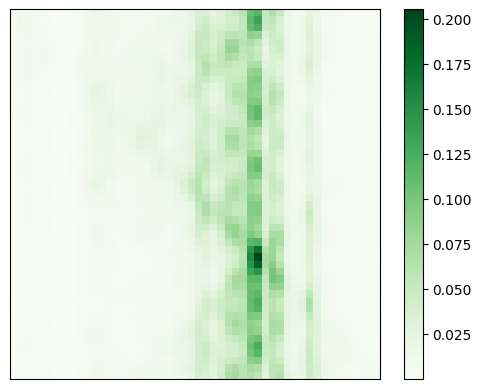

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_attention(attn_matrix):
    """Plot attention matrix without any axis labels or ticks."""
    fig, ax = plt.subplots()
    cax = ax.matshow(attn_matrix, cmap="Greens")
    fig.colorbar(cax)

    ax.set_xticks([])
    ax.set_yticks([])

    plt.show()



plot_attention(attn_matrix_no.squeeze(0).detach().numpy())
plot_attention(attn_matrix_lin.squeeze(0).detach().numpy())
plot_attention(attn_matrix_per.squeeze(0).detach().numpy())